# The restart acceleration trick: A cure for the heavy tail of wasted time

Ever wondered why restarting stuff, possibly multiple times, seems to fix problems?  For example, downloading a webpage or running an optimization algorithm from random initializations.  Today, we'll get into the math behind why random restarts often accelerate the time until completion.  Our discussion will focus on restart acceleration for speeding up computer algorithms, but the concepts extend to other restartable processes.

A [Las Vegas algorithm](https://en.wikipedia.org/wiki/Las_Vegas_algorithm) is an algorithm with an *uncertain* runtime (i.e., time until completion), but *certain* correctness.  Thus, it is "dual" to the more familiar [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_algorithm) family of algorithms, which have *certain* runtime, but *uncertain* correctness.  Put differently, when a Las Vegas algorithm halts, its output will be correct, but the time until it halts (runtime) is a random variable.  Thus, the algorithm has a runtime *distribution*.  

In its most general form, the restart acceleration trick eliminates heavy tails of the runtime distribution.  If the distribution is not [heavy-tailed](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) (or [bounded heavy-tailed](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.8427&rep=rep1&type=pdf)), then this trick will generally not accelerate the algorithm.

**The random restart wrapper:** The generic strategy for accelerating Las Vegas algorithms will determine a time-limiting policy, which will improve the overall algorithm's runtime distribution.  To start, we will assume that the entire runtime distribution is known.

In [1]:
from arsenal import timelimit, Timeout
def restart_acceleration(alg, policy):
    while True:  # repeat until solved...
        try:
            with timelimit(policy()):  # Run `alg` for at most `policy()` seconds
                return alg()           # if the alg halted within timelimit, output result.
        except Timeout:
            pass

**How it works**: If the algorithm halted within the chosen time limit, the wrapper also halts with the algorithm's result.  Otherwise, the wrapper runs the algorithm again, hoping to get luckier.

Some surprising results:

- When the runtime distribution is known, the optimal policy for runtime budgets is a fixed constant threshold! This is somewhat surprising - I will give a simple argument for why it is true.  

- When the runtime distribution is not known, there exists a universal strategy, which retries under a universal sequence of runtime thresholds.

The seminal paper on this topic is 
- Luby, Sinclair, and Zuckerman. 1993. [Optimal Speedup of Las Vegas Algorithms](http://http.icsi.berkeley.edu/ftp/global/pub/techreports/1993/tr-93-010.pdf).

Lots of details (e.g., CDF, higher-order moments, optimality conditions) are worked out in the following paper.  They also account for constant restart overhead, which is a very nice detail since in practice restarts are not free.
- van Moorsel and Katinka Wolter. 2004. [Analysis and Algorithms for Restart](https://dl.acm.org/citation.cfm?id=1026089).

I will draw heavily on both this papers in this notebook.

## Simulation

Let's set up some simple heavy-tailed distributions to play with. (A quick reference for some heavy-tailed distributions:
[Pareto](https://en.wikipedia.org/wiki/Pareto_distribution), [Log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution), [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution), [Fréchet](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distribution).)


In [2]:
import numpy as np, pylab as pl, scipy.stats as st
from arsenal.maths import mean_confidence_interval
from scipy.integrate import quad
from arsenal import iterview

# define a runtime distribution (uncomment to change the distribution we use throughout the notebook)
d = st.lognorm(2.)
#d = st.weibull_min(.5)  # heavy-tailed when parameter < 1
#d = st.pareto(1.1)     # variance is infinite for < 2
tmin = d.ppf(.01)
tmax = d.ppf(.9)
overhead = .2

print(f'average runtime: {d.mean():g}, variance: {d.var():g}')

average runtime: 7.38906, variance: 2926.36


### Expected capped running time

The following is recursive definition of the expected cost of a policy $\tau$ with a fixed restart-overhead penalty $\omega \ge 0$.  We require $\tau \ge \min\{ t \mid p(t) > 0 \}$ to avoid dividing by zero.

$$
T = 
\underbrace{p(t \le \tau)}_{\text{prob of done}}
\cdot 
\underbrace{\mathbb{E}_p[ t \mid t \le \tau ]}_{\text{cost given done}}    
+
\underbrace{(1 - p( t \le \tau))}_{\text{prob of retry}}
\cdot
\underbrace{(\overbrace{\tau}^{\text{fixed cost}} 
+ 
\overbrace{\omega}^{\text{fixed overhead cost}} 
+ 
\overbrace{T}^{\text{recursion}})}_{\text{cost given restart}}
$$

Solving the linear recurrence for $T$, we obtain

$$
\begin{align}
T &= 
\underbrace{\mathbb{E}_p[t |t \le \tau]}_{\text{cost given no restart}}
+
\underbrace{\frac{1-p(t \le \tau)}{p(t \le \tau)}}_{\text{restart rate}}
\cdot 
\underbrace{(\omega + \tau)}_{\text{cost of each restart}}.
\end{align}
$$

Remarks: 
 - This decision problem can be formalized as a simple two-state MDP (a terminal and non-terminal state) with actions corresponding to the threshold values.

 - Although the analysis below does not directly show this.  We know that all MDPs have an optimal policy that is pure and stationary (i.e., deterministic and fixed over time).  Thus, the optimal policy in our setting is a fixed threshold $\tau^*$.

 - The expected value isn't the only reasonable choice of what to optimize.  It is possible to minimize higher-order moments as well as the expected value.  It is also possible to minimize quantiles and the probability of completion by a budget.

In [3]:
def T(τ, ω):
    "Expected runtime with restart threshold τ and overhead ω."
    p = d.cdf(τ)
    return conditional_mean(0, τ) + (1-p)/p * (τ + ω)

@np.vectorize
def conditional_mean(a, b):
    "E[T | a <= T < b]"
    return d.expect(lambda x: x, a, b, conditional=True)

In [4]:
ts = np.linspace(tmin, tmax, 100)
Ts = T(ts, overhead)

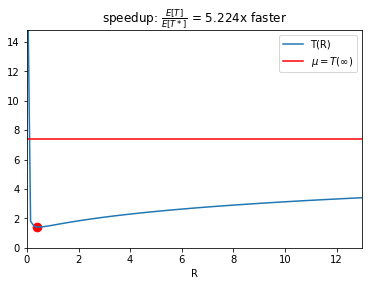

In [5]:
pl.plot(ts, Ts, label=r'T(R)')
pl.scatter(ts[Ts.argmin()], [Ts.min()], marker='o', c='r', s=75)

rstar = ts[Ts.argmin()]
pl.title(r'speedup: $\frac{E[T]}{E[T*]}$ = %.4gx faster' % (d.mean()/Ts.min()))
pl.axhline(d.mean(), c='r', label=r'$\mu = T(\infty)$')

pl.xlim(ts.min(), ts.max()) ; pl.ylim(0, d.mean()*2)

pl.xlim(0, ts.max()); pl.legend(loc='best'); pl.xlabel('R'); #pl.xscale('log'); pl.yscale('log');

### Unknown runtime distribution

When the runtime distribution is not known, there are still strategies which can provide acceleration.  Although, now there is an important constant factor, which might result in slower performance.

**Luby's universal strategy:** The expected runtime of the universal strategy is bounded by $\mathcal{O}(T(\tau^*) \log T(\tau^*))$.

In [6]:
def _luby():
    
    def h(k):
        if k == 0:
            yield 1
        else:
            for j in range(k):
                yield from h(j)
            yield 2 ** k
    
    i = 0
    while True:
        yield from h(i)
        i += 1

def universal(scale=1, base=2):
    "Generate the universal threshold sequence"
    for x in _luby():
        if base != 2:
            yield scale * base ** np.log2(x)
        else:
            yield scale * x
            
            
from arsenal.iterextras import take        
assert [1, 
        1, 2, 
        1, 1, 2, 4, 
        1, 1, 2, 1, 1, 2, 4, 8,
        1] == list(take(16, _luby()))

**Geometric sequence:** An alternative sequence, which often works better in practice, is a gemetric sequence.  Note, however, that this sequence can suffer *unbounded* regret in the worst case, unlike the universal sequence.

In [7]:
def geometric(scale, base=2.0):
    "Generate the geometrically increasing threshold sequence"
    assert base > 1
    i = 0
    while True:
        i += 1
        yield scale * base**i         

Let's compare the strategies.

In [8]:
from arsenal import restore_random_state

def _simulate(policy, seed):
    with restore_random_state(seed):
        total = 0.0
        while True:
            r = d.rvs()
            R = policy()           # this version uses a callable policy
            total += min(r, R)
            if r <= R:
                return total
            total += overhead

M = 10000
seeds = np.random.randint(0, 2**32, size=M).astype(int)  # use common random numbers
U = np.array([_simulate(universal(1, 2).__next__, seed=s) for s in seeds])
G = np.array([_simulate(geometric(1, 2).__next__, seed=s) for s in seeds])
O = np.array([_simulate(lambda: rstar, seed=s) for s in seeds])
D = d.rvs(M)

# First and second moments
print(f'uncapped:  {d.mean():.2f} {np.mean(D**2):.2f}')
print(f'universal: {U.mean():.2f} {np.mean(U**2):.2f}')
print(f'geometric: {G.mean():.2f} {np.mean(G**2):.2f}')
print(f'optimized: {O.mean():.2f} {np.mean(O**2):.2f}')

uncapped:  7.39 1081.91
universal: 1.59 5.99
geometric: 2.04 12.44
optimized: 1.42 4.43


## Closing remarks

We now see why restarts can provide useful acceleration for Las Vegas algorithms.  Hopefully, the generalization to other restartable processes is reasonably clear.  In the appendix of this article there is a lot more interesting properties and details worked out for reference.

This notebook is available for download [here](https://github.com/timvieira/blog/blob/master/content/Restart-acceleration.ipynb).  

I am very happy to answer questions! There are many ways to do that: comment at the end of this document, Tweet at `@xtimv`, or email `tim.f.vieira@gmail.com`.

If you found this article interesting please consider sharing it on social media.  If you found this article useful please cite it
```bibtex
@software{vieira-restart-acceleration,
  author = {Tim Vieira},
  title = {The restart acceleration trick: A cure for the heavy tail of wasted time},
  year = {2019},
  url = {https://github.com/timvieira/blog/blob/master/content/Optimal-Restarts.ipynb}
}



```





# Appendix

In this section, I will worked out a bunch of lower-level details, which might be of interest to many readers.

### Optimizing $\tau$

In the discrete case, the optimal $\tau$ can be computed be approximating by enumeration.

In the continuous case, the optimal $\tau$ can be computed in "the usual way" (i.e., by solving for $\tau$ such that $\frac{\partial v}{\partial \tau}$ is equal to zero; and check the sign of the second derivative).  Setting the derivative equal to zero we get (after a bunch of simplification),

$$
\frac{\partial T}{\partial \tau} = 0
\quad\Longleftrightarrow\quad
\frac{1-p(t \le \tau)}{p(\tau)} - \omega = T
$$

Remarks

- The optimally capped expectation (as well as higher-order moments) are always finite - even when the underlying RTD puts a positive probability on nontermination.

- Optimally tuned thresholds do not always decrease the expected runtime (or higher-order moments).  They are most useful in cases where the runtime distribution has a positive probability of nontermination or, more generally, the runtime distribution is heavy-tailed.

- The objective is generally nonconvex, so the gradient condition is necessary, but not sufficient.

Below, we check whether the optimality conditions that we derived are consistent with our running example. The test is an "eyeball" test that the optimal speedup is at the point where the $T(\tau)$ curve (blue) and $\frac{1}{h(t)} -\omega = \frac{1-p(t \le \tau)}{p(\tau)} - \omega$ (orange) intersect.  The function $h(t)$ is the ($\omega$-shifted) [hazard-rate function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function).

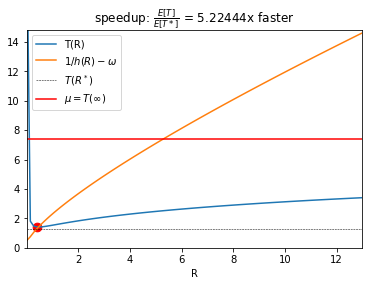

In [9]:
ts = np.linspace(tmin, tmax, 100)
Ts = T(ts, overhead)

H = lambda t: d.pdf(t)/d.sf(t)   # hazard-rate function

pl.plot(ts, Ts, label=r'T(R)')
pl.plot(ts, 1/H(ts)-overhead, label=r'$1/h(R)-\omega$')     # inverse of the hazard-rate function
pl.scatter(ts[Ts.argmin()], [Ts.min()], marker='o', c='r', s=75)
pl.xlim(ts.min(), ts.max()) #; pl.ylim(0, m*2)

rstar = ts[Ts.argmin()]

pl.title(r'speedup: $\frac{E[T]}{E[T*]}$ = %gx faster' % (d.mean()/Ts.min()))
pl.axhline(1/H(rstar)-overhead, c='k', lw=0.5, linestyle='--', label=r'$T(R^*)$');
pl.axhline(d.mean(), c='r', label=r'$\mu = T(\infty)$')
pl.ylim(0, d.mean()*2); pl.legend(loc='best'); pl.xlabel('R'); #pl.xscale('log'); pl.yscale('log')

### Runtime distribution conditioned on capping

To study our restarting trick, it will be useful to have the CDF of the $(\tau, \omega)$-restarted distribution.  Later in this document, I work out the generalization of this distribution functions for non-stationary restart policies such as the universal sequence.

The restarted distribution has some interesting periodic structure, which we'll discuss below.

#### CDF $F_{\tau, \omega}(t)$

In [10]:
def capped_cdf(τ, ω):
    "Analytical CDF conditioned on a capping threshold τ and overhead ω."    
    decay = d.sf(τ)
    def F(t):
        # Careful handling of gaps due to restarting and overhead.
        k,r = divmod(t, τ + ω)          # number of restarts
        if r <= τ:                      # overhead portion of the restart
            # distribution is scaled (by d.sf(τ)**k) and clipped (r <= τ <= τ + ω)
            return 1 - decay**k * d.sf(r)
        else:
            return 1 - decay**(k+1)
    return F

#### PDF $f_{\tau, \omega}(t)$

In [11]:
def capped_pdf(τ, ω):
    "Analytical PDF conditioned on a capping threshold τ and overhead ω."
    decay = d.sf(τ)
    def f(t):
        k,r = divmod(t, τ + ω)
        if r <= τ:
            return decay**k * d.pdf(r)            
        else:
            return 0
    return f

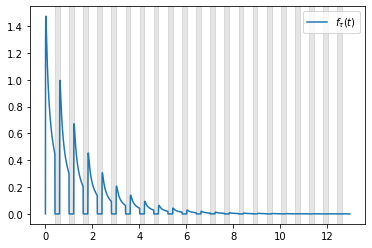

In [12]:
ts = np.linspace(0, d.ppf(.9), 10000)

# there should be gaps in the PDF at regular intervals
for i in range(1, int(ts.max() / (overhead + rstar))+1):
    tt = i * (overhead + rstar)
    pl.axvspan(tt-overhead, tt, color='k', alpha=.1)

P = capped_pdf(rstar, overhead)
ps = np.array([P(t) for t in ts])
pl.plot(ts, ps, label=r'$f_\tau(t)$')
pl.legend(loc='best'); #pl.yscale('log')

### Periodicity in the capped PDF

The truncated PDF has an interesting repeating structure.  The original distribution's $\tau$-truncated PDF repeats itself every $\tau+\omega$ units of time.  However, when it does repeat itself, shrinks by a factor of $F(\tau)$ each time.

In [13]:
def truncated_pdf(d, a, b):
    def f(t):
        return (a <= t) * (t <= b) * d.pdf(t) / (d.cdf(b) - d.cdf(a))
    return f

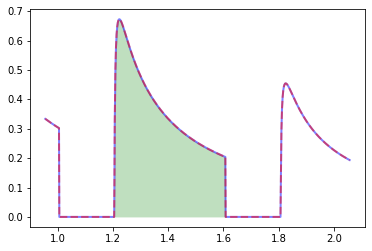

In [14]:
period = 2
extra = 0.25

λ = (1-d.cdf(rstar))

ts = np.linspace((period + 0) * (rstar + overhead) - extra, 
                 (period + 1) * (rstar + overhead) + extra, 1000)

pl.plot(ts, [P(t) for t in ts], label=r'$f_\tau(t)$', c='b', alpha=0.5, lw=2)

# Show periodic self-similarity 
# the next period's in PDF is rescaled (by inverse decay) and shifted one period (rstar + overhead)
pl.plot(ts, [1/λ * P(t + (rstar + overhead)) for t in ts],
        c='r', alpha=.5, linestyle='--', lw=2)

# Show the relationship to d's (0,τ*)-truncated PDF.
pl.fill_between(ts, 0,  (1-λ) * λ**period * truncated_pdf(d, 0, rstar)(ts - (period)*(rstar + overhead)), 
        color='g', alpha=0.25, lw=0);

### Capping eliminates heavy tails

log-log survival plot:  This plot shows us if we have heavy tails: a heavy-tailed distribution will have a linear slope, and a light-tailed distribution will go to zero more quickly than linear.

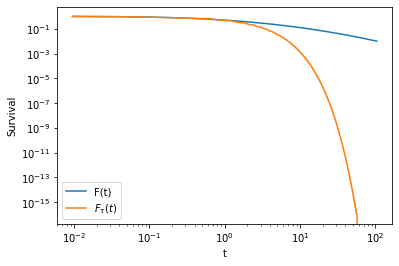

In [15]:
ts = np.linspace(tmin, d.ppf(.99), 10000)

pl.plot(ts, 1-d.cdf(ts), label='F(t)')
pl.plot(ts, [1-capped_cdf(rstar, overhead)(t) for t in ts], label=r'$F_\tau(t)$')
pl.yscale('log'); pl.xscale('log'); pl.xlabel('t'); pl.ylabel('Survival'); pl.legend(loc='best');

## Tests for capped CDF and PDF

Get a large sample from the restart distribution.

In [16]:
def simulate(R, seeds):
    def _simulate(R, seed):
        "simulate capped-restart distribution"
        with restore_random_state(seed):
            total = 0.0
            while True:
                r = d.rvs()
                total += min(r, R)
                if r <= R:
                    return total
                total += overhead
    return [_simulate(R, seed) for seed in seeds]

In [17]:
M = 40000
seeds = np.random.randint(0, 2**32, size=M).astype(int)
S = simulate(rstar, seeds)

Compare the analytical CDF to the empirical CDF of the big sample.

In [18]:
from arsenal.maths import cdf
e = cdf(S)   # empirical CDF of the optimal threshold.

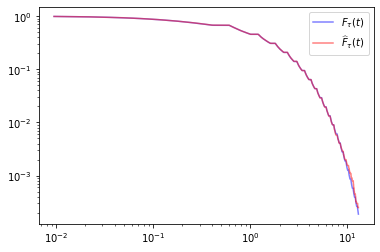

In [19]:
C = capped_cdf(rstar, overhead)

ts = np.linspace(tmin, tmax, 1000)   # estimate gets unreliable out in the tail
Cs = [1-C(t) for t in ts]

pl.plot(ts, Cs, label=r'$F_\tau(t)$', c='b', alpha=0.5)
pl.plot(ts, 1-e(ts), label=r'$\widehat{F}_\tau(t)$', c='r', alpha=0.5)
pl.legend(loc='best'); pl.yscale('log'); pl.xscale('log');

Compare the analytical PDF to a histogram fit to the big sample.

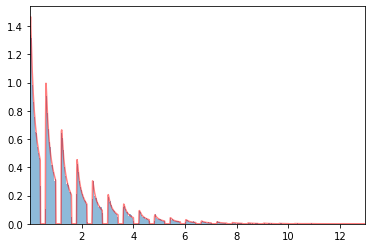

In [20]:
P = capped_pdf(rstar, overhead)
ps = [P(t) for t in ts]

# Show the histogram
pl.hist(S, bins=500, density=True, alpha=0.5)
pl.xlim(ts.min(), ts.max())

# The PDF should equal the gradient of the CDF.
pl.plot(ts, ps, c='r', alpha=0.5);

### Tests for truncated mean

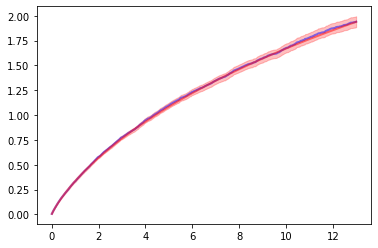

In [21]:
# test that the right-truncated mean estimate matches rejection sampling
N = 10000
S = d.rvs(N)

# a more efficient estimator would generate truncated samples so all samples are 'accepted' 
def simulate_tm(t):
    return mean_confidence_interval(S[S <= t])

mi,lb,ub = zip(*[simulate_tm(t) for t in ts])
pl.fill_between(ts, lb, ub, color='r', alpha=0.25)
pl.plot(ts, mi, c='b', alpha=0.5, lw=2)
pl.plot(ts, conditional_mean(0, ts), c='r', lw=2, alpha=0.5);

### Alternative expressions for expected capped runtime $T$

I have used the expression below for expected capped runtime.

$$
T(\tau,\omega) = \mathbb{E}_p[t |t \le \tau] + \frac{1-p(t \le \tau)}{p(t \le \tau)} \cdot (\omega + \tau).
$$

However, a number of papers on the subject make use of the following equation,

$$
T(\tau, \omega) 
= \frac{\tau - \int_{0}^\tau F(t) \mathrm{d} t}{ F(\tau) } + \omega \frac{1-F(\tau)}{F(\tau)}
$$

We can also express $T$ in terms of the survival function $S(t) \overset{\text{def}}{=} (1-F(t))$

$$
T(\tau, \omega)
= \frac{\int_{0}^\tau S(t) \mathrm{d} t}{ 1 - S(\tau) } + \omega \frac{S(\tau)}{1-S(\tau)}
$$

In [22]:
@np.vectorize
def L(τ, ω):
    "Equivalent expression for expected runtime given the threshold `b`."
    p = d.cdf(τ)
    return (τ - quad(lambda x: d.cdf(x), 0, τ)[0]) / p + ω * (1-p) / p

ts = np.linspace(d.ppf(.05), d.ppf(.9), 100)

Ts = T(ts, overhead)
Ls = L(ts, overhead)

#pl.plot(ts, Ls, label=r'$L(R)$', c='r', alpha=0.5)
#pl.plot(ts, Ts, label=r'$T(R)$', c='b', alpha=0.5)

rerr = np.abs(Ts - Ls) / np.abs(Ts)
assert rerr.max() <= 0.01, rerr

## PDF and CDF of non-uniform policies

In [23]:
M = 20000
U_args = (1, 2)
seeds = np.random.randint(0, 2**32, size=M).astype(int)  # use common random numbers
U = np.array([_simulate(universal(*U_args).__next__, seed=s) for s in iterview(seeds)])

100.0% (20000/20000) [================================================] 00:00:02


In [31]:
class CachedPolicy:
    def __init__(self, seq, overhead, tmax):
        self.N = 0; self.s = []; self.t = []; self.decay = []
        T = 0; D = 1 
        for x in seq():
            if T > tmax: break
            self.s.append(x)
            self.t.append(T)
            self.decay.append(D)
            D *= d.sf(x)
            T += x + overhead
            self.N += 1
        self.overhead = overhead
        
    def __call__(self, k):
        return self.s[k]
    
    def invert(self, t):
        for k in range(self.N - 1):
            if self.t[k] <= t < self.t[k+1]:   # could use binary search for efficiency
                return k, t - self.t[k]
        assert False, f'failed to invert policy t={t} tmax={max(self.t)}'
        
    def plot(self):
        "Show the gaps and restart periods"
        for t in self.t:
            pl.axvspan(t - self.overhead, t, color='k', alpha=.1)

    def pdf(self, t):
        "Analytical PDF conditioned on a capping policy τ and overhead ω."
        k, r = self.invert(t)
        if r <= self.s[k] :   # Are we in an overhead gap period?
            return self.decay[k] * d.pdf(r)            
        else:
            return 0

    def cdf(self, t):
        "Analytical CDF conditioned on a capping threshold τ and overhead ω."    
        k, r = self.invert(t)
        if r <= self.s[k] :   # Are we in an overhead gap period?
            return 1 - self.decay[k] * d.sf(r)
        else:
            return 1 - self.decay[k+1]

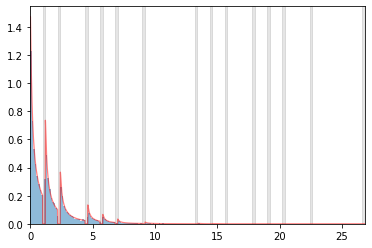

In [25]:
ts = np.linspace(d.ppf(.01), d.ppf(.95), 3000)

luby = CachedPolicy(lambda: universal(*U_args), overhead, 2*ts.max())

luby.plot()
pl.plot(ts, [luby.pdf(t) for t in ts], color='r', alpha=.5, lw=1.25)

pl.hist(U, bins=200, density=True, alpha=0.5)
pl.xlim(0, ts.max());

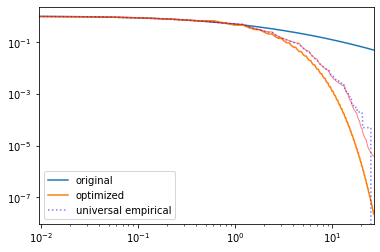

In [30]:
Ucdf = cdf(U)

pl.plot(ts, d.sf(ts), label='original')
pl.plot(ts, [1-C(t) for t in ts], label='optimized')
pl.plot(ts, [1-Ucdf(t) for t in ts], label='universal empirical', color='b', alpha=.5, linestyle=':')
pl.plot(ts, [1-luby.cdf(t) for t in ts], color='r', alpha=.5, lw=1)

pl.xscale('log'); pl.yscale('log'); pl.xlim(ts.min(), ts.max()); pl.legend(loc='best');